# SETUP

In [ ]:
!conda info --envs

In [ ]:
import numpy as np
import itertools
import requests
import faster_than_requests as ftreq
import datetime
import time
import json
import sys
from datetime import datetime
import pickle
import pandas as pd
import rasterio as rio
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from rasterio.transform import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [ ]:
print("matplotlib",matplotlib.__version__)
print("seaborn",sns.__version__)
print("numpy",np.__version__)
print("pandas",pd.__version__)
print("python",sys.version)

The Forecast Data API supports HTTP compression. We heartily recommend using it, as it will make responses much smaller over the wire. To enable it, simply add an `Accept-Encoding: gzip` header to your request.

# Putting it all together: Functions to get weather, create each day's weather from DarkSky json and to upsample each array then store the dictionary of arrays out

## Get Weather Data Functions and call

In [2]:
# Function to get dates of fire in pertinent area from raster file.
def get_fire_dates(yr,path,filename):
    """Get all the dates for a given year that there was fire
    in the raster being studied
    """
    import rasterio as rio
    import numpy as np
    from datetime import datetime
    
    f = path+filename
    # Use the firedata raster to find the day of year 
    with rio.open(f,'r') as rast:
        rastdata = rast.read(1)
    
    # Get unique days of the year there was a pixel on a fireline, as well as counts
    uniq = np.unique(rastdata, return_counts=True)
    days = uniq[0]
    counts = uniq[1]
    
    # Error check that counts are greater than 0
    if np.count_nonzero(counts) > 0:
        days = days[days > 0]  # remove the -9999 no data values

    # Create list of dates for DOY on fireline, date format = ['2016-12-16']
    # time = date+'T12:00:00'
    fire_dates = []
    for day in days:
        s = yr + '-'+ str(day)
        d = datetime.strptime(s,'%Y-%j')
        s2 = str(d.strftime("%Y-%m-%d")) + 'T12:00:00'
        fire_dates.append(s2)
    
    return fire_dates

In [3]:
def fire_weather(pairs,fire_dates,key):
    """Function to loop through all pairs of lat/long and get the daily weather
    for each point from DarkSky
    Input: list of pairs of lat/long, list of dates, API Key
    Output: Dictionary of list of daily weather jsons
    """
    import requests
    s = requests.Session()
    s.auth = ('user', 'pass')
    s.headers.update({'Accept-Encoding':'gzip'})

    
    yr_weath = {}
    for date in fire_dates:
        # Call function to get weather for specified date
        data_for_date = getweather(s,pairs,date,key)
        yr_weath.update({date:data_for_date})
        
    return yr_weath

In [4]:
def getweather(s,coordinates,date,key):
    """ Function to take the set of coordinates and get the daily
    weather for a given date. rain, hi and low temps, humidity
    wind speed and direction and cloud cover only.
    
    Called from fire_weather
    
    Input: Date, API Key and list of coordinate pairs (lat,long)
    Output: list of jsons
    """
    import requests
    import json
    
    # items to exclude from call
    blocks = '[currently,minutely,hourly,alerts]'

    # Units for call (km/h, deg C, kPa, mm precip)
    units = 'ca'
    
    # Compression for call
    headers = {'Accept-Encoding':'gzip'}
    
    data_out = []
    for pair in coordinates:
        lat = str(pair[0])
        long = str(pair[1])
        # set the query string for darksky
        query = ('https://api.darksky.net/forecast/'+key+'/'+ 
            lat+','+long+','+date+'?exclude=' 
            +blocks+'&units='+units)
        # Make the call to Dark Sky to get all the data for that date and location
        r=s.get(query,headers=headers)
        
        # get the weather data from the request return
        weather=r.json()
        
        # write the jsons as items in the output data list
        data_out.append(weather)
    
    return data_out

In [1]:
def setup(path,filename):
    """ one time function to set limits of bounding box for weather
    in lat / long
    Input: raster
    Output: pairs of lat/long, lats and longs    
    """
    import rasterio as rio
    import numpy as np
    
    filestring = path+filename
    with rio.open(filestring) as f:
        left,bottom,right,top = f.bounds
    
    # for rectangle
    bb_long = [left,right,right,left,left]
    bb_lat = [top,top,bottom,bottom,top]
    
    # Create grid of lat/long pairs for retrieving weather data
    min_long = min(bb_long)
    max_long = max(bb_long)
    min_lat = min(bb_lat)
    max_lat = max(bb_lat)

    # 15 x 15 grid
    spaces = 15
    longs = np.linspace(min_long,max_long,spaces)
    lats = np.linspace(min_lat,max_lat,spaces)
    pairs = [(lat,long) for lat in lats for long in longs]
    
    return (pairs,lats,longs)

In [17]:
def weather(year):
    """Function to run weather functions to get weather data from DarkSky
    for each day in the given year there is a fire in a pixel in the area under question
    """
    import pickle
    
    # Non-Request related setup
    path = '../data/GlobalFire/'+year+'/'
    filename = 'BBfirelineCA.tif'  # use fireline to get all pixels involved in a fire in that year

    # Get pairs of lats and longs
    pairs,lats,longs = setup(path,filename)

    # Get dates for required request
    fire_dates = get_fire_dates(year,path,filename)

    # Dark Sky API key (Laura Chutny)
    key = '5ffac5f056d341c6296cba58fa96e9ba'
    # Make requests to DarkSky
    yr_weather = fire_weather(pairs,fire_dates,key)  # Dictionary of jsons

    # Pickle out the jsons to avoid another call to API (just in case something goes wrong)
    weathfile = path+'weatherjsons.pickle'
    with open(weathfile,'wb') as f:
        pickle.dump(yr_weather,f,pickle.HIGHEST_PROTOCOL)
    print(f"{weathfile} printed for year {year}")

    return fire_dates

In [7]:
%%time
# when doing with an open API session, takes about 45-55 minutes per year
years = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2014','2015','2016']
fire_dates={}
fire_date_nums={}
for year in years:
    # Commenting out this next line to make sure we don't accidentally run the weather api.
    #fds = weather(year)
    fire_dates[year]=fds
    fire_date_nums[year]=len(fds)

../data/GlobalFire/2014/weatherjsons.pickle printed for year 2014
../data/GlobalFire/2015/weatherjsons.pickle printed for year 2015
../data/GlobalFire/2016/weatherjsons.pickle printed for year 2016
Wall time: 2h 14min 10s


## Change jsons to dataframes and then rasters and reproject before pickling out

In [18]:
def check_point(info,rain=False):
    """ to check if there is a value for that weather element and provide 
    either None or the value back
    Used in function date_df only
    """
    if info:
        return info
    elif (not info and rain):
        return 0.0        
    else:
        return None

In [41]:
def date_df(data_out):
    """ Function to take the list of jsons for each lat/long from one date
    of daily weather request and create a pandas dataframe
    
    Input: list of jsons containing the weather data for one day
    Output: pandas dataframe
    """
    from datetime import datetime
    import pandas as pd
    
    data_convert=[]
    # Titles for the data
    coltitles = ['date','latitude','longitude','rainint','raintot','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']
    data_convert.append(coltitles)
    # Loope through all the geopoints to get the data
    for point in data_out:
        lat = point['latitude']
        long = point['longitude']
        daily = point.get('daily')
        if daily:
            data = daily['data'][0]
            date = datetime.fromtimestamp(data['time']).strftime('%Y-%m-%d')
            rainint = data.get('precipIntensityMax')
            raintot = data.get('precipAccumulation')
            hitemp = data.get('temperatureHigh')
            lotemp = data.get('temperatureLow')
            humidity = data.get('humidity')
            windspd = data.get('windSpeed')
            winddir = data.get('windBearing')
            clouds = data.get('cloudCover')
            point = [date,lat,long,check_point(rainint,1),check_point(raintot,1), \
                     check_point(hitemp,0),check_point(lotemp,0), \
                     check_point(humidity,0),check_point(windspd,0), \
                     check_point(winddir,0), check_point(clouds,0)] 
            data_convert.append(point)
            
        else:
            point = None
            
    df = pd.DataFrame(data_convert[1:], columns = data_convert[0])
    
    return df

In [43]:
def jsons_to_arrays(date_jsons,pairs):
    """ Take list of jsons for weather for area being studied (YxY jsons)
    for 1 day and turn them into a dictionary of numpy arrays
    
    Input: list of jsons - 1 per lat/long point and pairs of lat/long
    Output: dictionary of numpy arrays - 1 for each weather type for given date
    """
    import pandas as pd
    import numpy as np
    
    # Input jsons to pandas dataframe:
    df = date_df(date_jsons)
          
    # Add Missing Rows to dataframe:
    # First get a paired list to determine if any rows are missing
    df['xx'] = list(zip(df['latitude'],df['longitude']))
    missing = pd.DataFrame({'xx':list(set(df['xx']) ^ set(pairs))})
    if not missing.empty:
        missing[['latitude','longitude']]=pd.DataFrame(missing['xx'].tolist(),index=missing.index)
        df = df.append(missing, ignore_index=True, sort=True)
    
    # Sort DataFrame to allow creation of rows in array.
    weather = ['rainint','raintot','High T','Low T','Humidity','Wind Speed','Wind Direction','Cloud Cover']
    weath_sort = df.to_records(index=False)
    weath_sort.sort(order=('latitude','longitude'))

    # Create Dictionary of Numpy Arrays
    weather_date = {}
    for var in weather:
        x = weath_sort[var].reshape(15,15)
        xx = np.flip(x,0)
        weather_date.update({var:xx})
        
    return weather_date

In [2]:
def new_meta(lats,longs):
    """ Calculate transform and meta data for 15x15 
    raster of lat/long data
    """
    from rasterio.transform import Affine
    
    # from https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data
    # See my imported sketches with the correct transforms
    
    #  Resolution
    xres = (longs[-1] - longs[0]) / 14
    yres = (lats[0] - lats[-1]) /14
    
    # affine transform - assumes each lat/long point is in the center of the pixel it represents
    src_transform = Affine.translation(longs[0] - xres / 2, lats[-1] - yres / 2) * Affine.scale(xres, yres)
    
    meta = {'driver':'GTiff','height':15, \
                'width':15,'count':1, \
                'dtype':'float64', 'crs':'+proj=latlong', \
                'transform':src_transform, 'nodata':-9999, \
                'compress':'lzw','interleave':'band'}
    
    return meta

In [3]:
def reproject_arrs(arrs,path,filename,src_meta):
    """Reproject the lat/long weather arrays to
    raster arrays with new CRS
    
    Input: Dictionary of numpy arrays holding 8 weather variables
    for one date in 15x15 grid based on lat/long, path and filename to raster
    and Source meta data
    Output: Dictionary of numpy arrays holding 8 weather variables
    for one date in grid to match firedata raster.
    """    
    import rasterio as rio
    import numpy as np
    from rasterio.warp import reproject, Resampling
    
    # Get reference meta data from raster
    file = path+filename
    with rio.open(file,'r') as ref:
        refdata = ref.read(1)  # data in raster
        refmeta = ref.meta # meta data in raster
        refres = ref.res # resolution in raster
    
    # Set destination transform and coordinate reference system
    dst_transform = refmeta['transform']
    dst_crs = refmeta['crs']

    # Get source transform and CRS
    src_transform = src_meta['transform']
    src_crs = src_meta['crs']
    
    refmeta['dtype'] = 'float64'
    
    dst_shape = refdata.shape
    destination = np.full(dst_shape, -9999.0)
    
    rp = {}
    for w,a in arrs.items():
        # clear the array before reprojecting each time
        destination = np.full(dst_shape, -9999.0)
        
        reproject(
            a,
            destination,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear)
        
        rp.update({str(w):destination})

    return rp

## Functions to get jsons into matrix form

In [44]:
# Create function to loop over all dates and write out the dictionary of basic arrays (not reprojected)
def all_weather(year):
    """Loop through all the dates for fire in a year and
    corresponding daily weather jsons (yr_weather), convert
    to numpy arrays and reproject the arrays, then save out the new dictionary
    
    Input: yearly weather pickled jsons from darksky as date keyed dictionary of jsons, with lat/long pairs as pairs and separate lists
    Output: write out the reprojected yearly weather arrays as pickle file
    """
    import datetime
    import pickle
    
    # Non-Request related setup
    path = '../data/GlobalFire/'+year+'/'
    filename = 'BBfirelineCA.tif'  # use fireline to get all pixels involved in a fire in that year
    weatherjsons = 'weatherjsons.pickle'  # use fireline to get all pixels involved in a fire in that year

    # Get pairs of lats and longs
    pairs,lats,longs = setup(path,filename)

    wj = path+weatherjsons
    with open(wj,'rb') as f:
        wj2 = pickle.load(f)   
    
    yr_weather={}
    for date,data in wj2.items():
        # Convert jsons to arrays for given date
        day_data = jsons_to_arrays(data,pairs)  #dictionary of numpy arrays - 1 array for each weather variable keyed by date
        dt = date[0:10]
        
        yr_weather.update({dt:day_data})
        
    # Pickle out the array dictionary:
    wafile = path+'weatherarrays.pickle'
    with open(wafile,'wb') as f2:
        pickle.dump(yr_weather,f2,pickle.HIGHEST_PROTOCOL)
    
    print(f"Jsons turned to arrays for year {year} and saved out")
    
    return 

In [51]:
%%time
years = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2014','2015','2016']
for year in years:
    all_weather(year)

Jsons turned to arrays for year 2003 and saved out
Jsons turned to arrays for year 2004 and saved out
Jsons turned to arrays for year 2005 and saved out
Jsons turned to arrays for year 2006 and saved out
Jsons turned to arrays for year 2007 and saved out
Jsons turned to arrays for year 2008 and saved out
Jsons turned to arrays for year 2009 and saved out
Jsons turned to arrays for year 2010 and saved out
Jsons turned to arrays for year 2011 and saved out
Jsons turned to arrays for year 2012 and saved out
Jsons turned to arrays for year 2014 and saved out
Jsons turned to arrays for year 2015 and saved out
Jsons turned to arrays for year 2016 and saved out
Wall time: 39.1 s


## Create reprojected arrays for each date and pickle out

In [4]:
# Create function to loop over all dates and write out the dictionary
def reproj_weather(year,path,weatherarrayfilename):
    """Loop through all the dates for fire in a year and
    corresponding daily weather jsons (yr_weather), convert
    to numpy arrays and reproject the arrays, then save out the new dictionary
    
    Input: yearly weather from darksky as date keyed dictionary of jsons, with lat/long pairs as pairs and separate lists
    Output: write out the reprojected yearly weather arrays as pickle file
    """
    import pickle
    
    refraster = 'BBspeedCA.tif'
    pairs,lats,longs=setup(path,refraster)
    src_meta = new_meta(lats,longs)
    
    weatherarrfilestring = path+weatherarrayfilename
    with open(weatherarrfilestring,'rb') as f:
        yr_weather = pickle.load(f)
    
    yr_rp_weather = {}    
    for date,data in yr_weather.items():
        
        # Reproject arrays
        reproj = reproject_arrs(data,path,refraster,src_meta)
        
        yr_rp_weather.update({date:reproj})
        
    # Pickle out the reprojected array dictionary:
    outfilestring = path + 'weather'+year+'data.pickle'
    with open(outfilestring,'wb') as f1:
        pickle.dump(yr_rp_weather,f1,pickle.HIGHEST_PROTOCOL)
        
    print(f"{outfilestring} printed for year {year}")
    
    return (len(yr_rp_weather))

In [5]:
%%time
#years = ['2003']
years = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2014','2015','2016']
for year in years:
    path = '../data/GlobalFire/'+year+'/'
    weatherarrayfile = 'weatherarrays.pickle'
    reproj_weather(year,path,weatherarrayfile)

../data/GlobalFire/2003/weather2003data.pickle printed for year 2003
../data/GlobalFire/2004/weather2004data.pickle printed for year 2004
../data/GlobalFire/2005/weather2005data.pickle printed for year 2005
../data/GlobalFire/2006/weather2006data.pickle printed for year 2006
../data/GlobalFire/2007/weather2007data.pickle printed for year 2007
../data/GlobalFire/2008/weather2008data.pickle printed for year 2008
../data/GlobalFire/2009/weather2009data.pickle printed for year 2009
../data/GlobalFire/2010/weather2010data.pickle printed for year 2010
../data/GlobalFire/2011/weather2011data.pickle printed for year 2011
../data/GlobalFire/2012/weather2012data.pickle printed for year 2012
../data/GlobalFire/2014/weather2014data.pickle printed for year 2014
../data/GlobalFire/2015/weather2015data.pickle printed for year 2015
../data/GlobalFire/2016/weather2016data.pickle printed for year 2016
Wall time: 23min 42s


# Check if data correctly reprojected

In [6]:
def plot_weather(day_weath):
    """ Plot all the weather components for that day"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig = plt.figure(figsize = (20,8))
    fig.subplots_adjust(hspace=0.4,wspace=0.4)
    i=1
    for key,data in day_weath.items():
        ax = fig.add_subplot(2,4,i)
        sns.heatmap(data)
        ax.set_title(key)
        i+=1
    plt.show()

Year2003


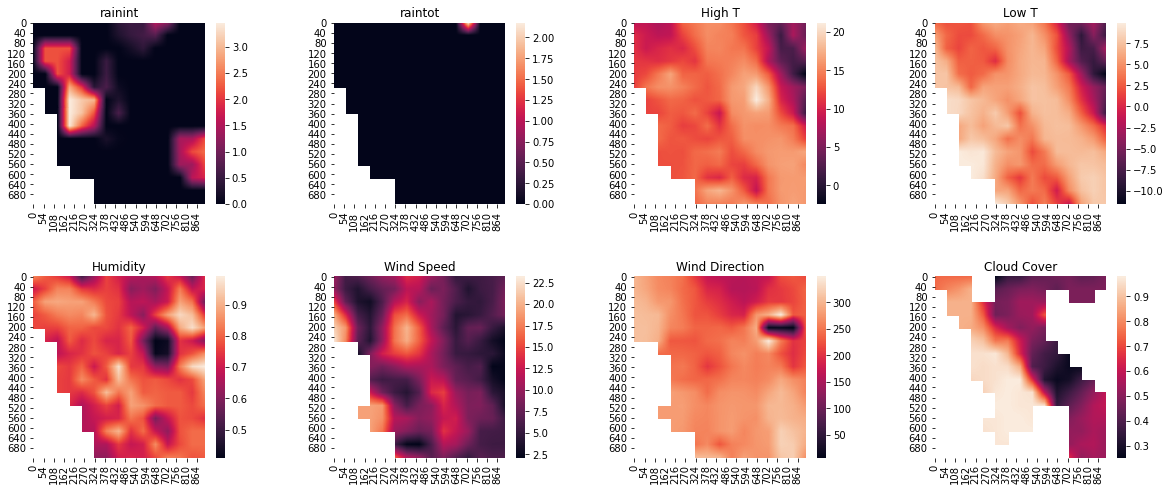

Year2004


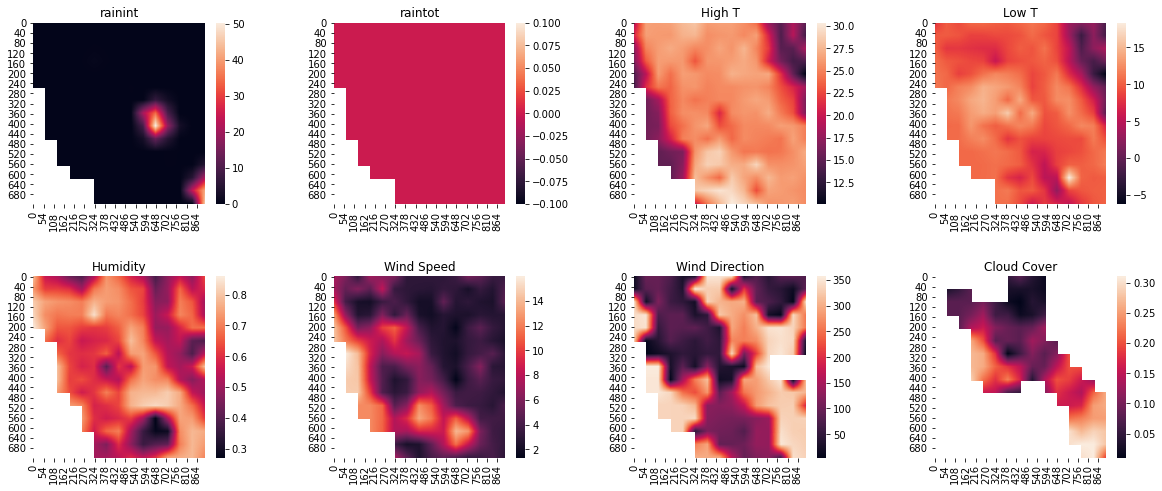

Year2005


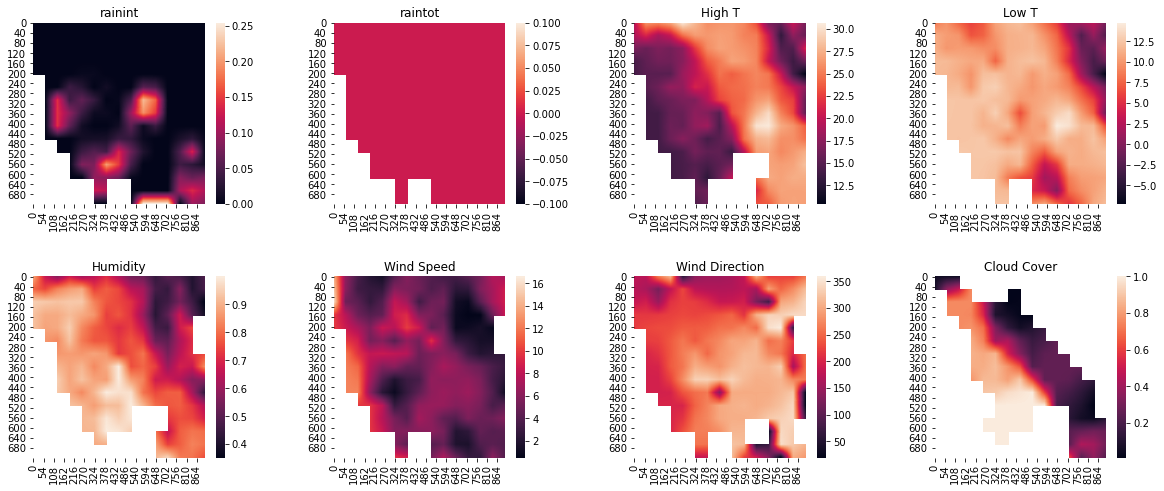

Year2006


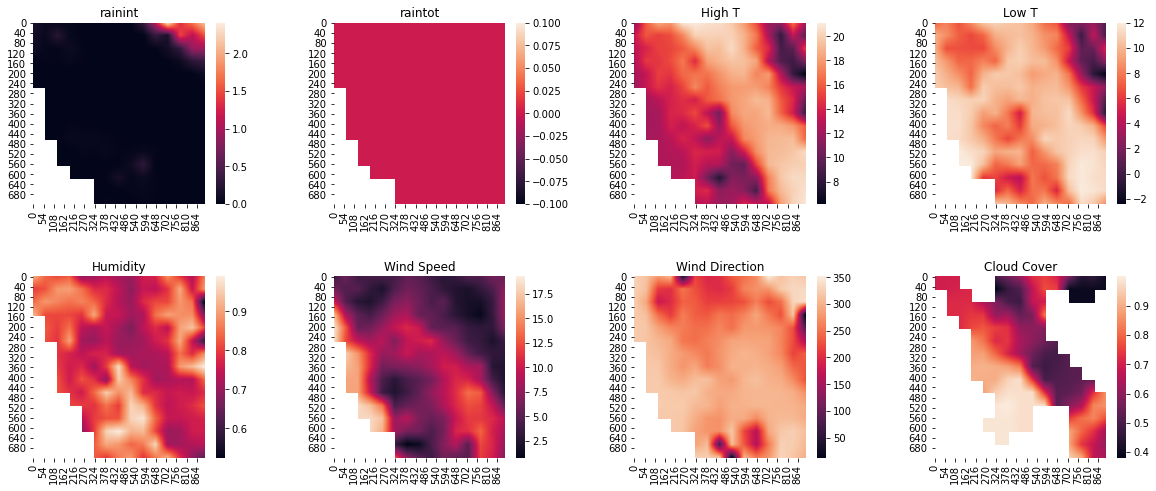

Year2007


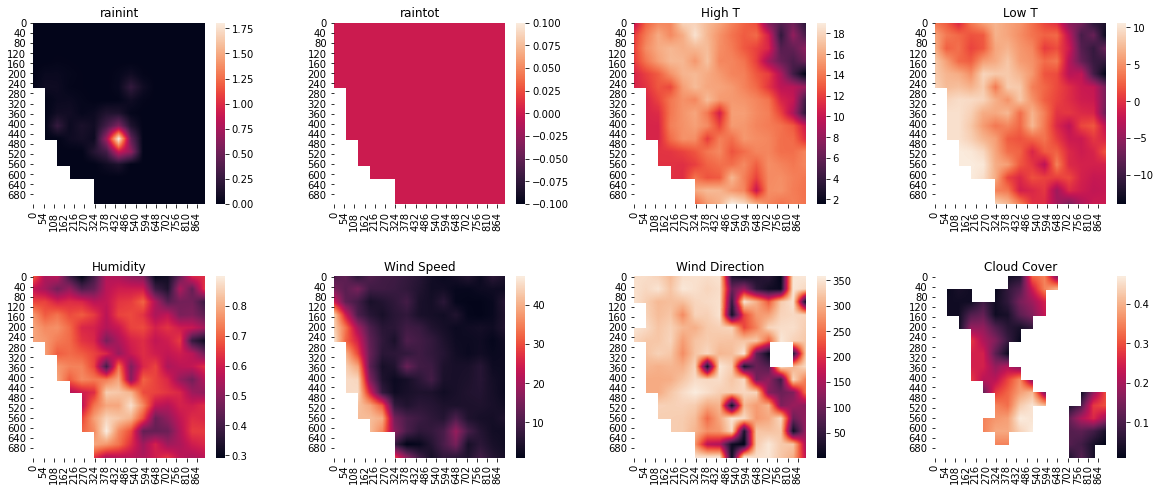

Year2008


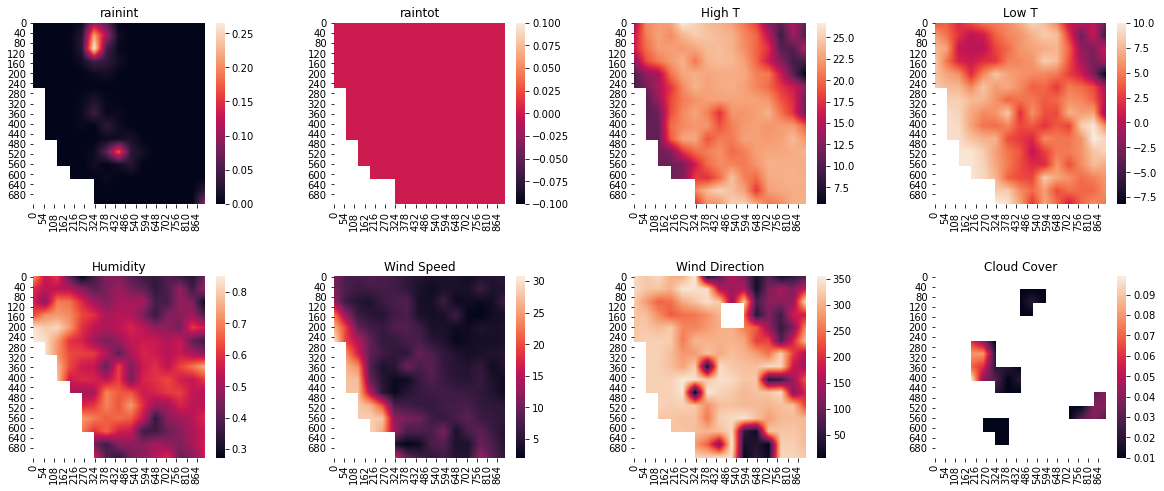

Year2009


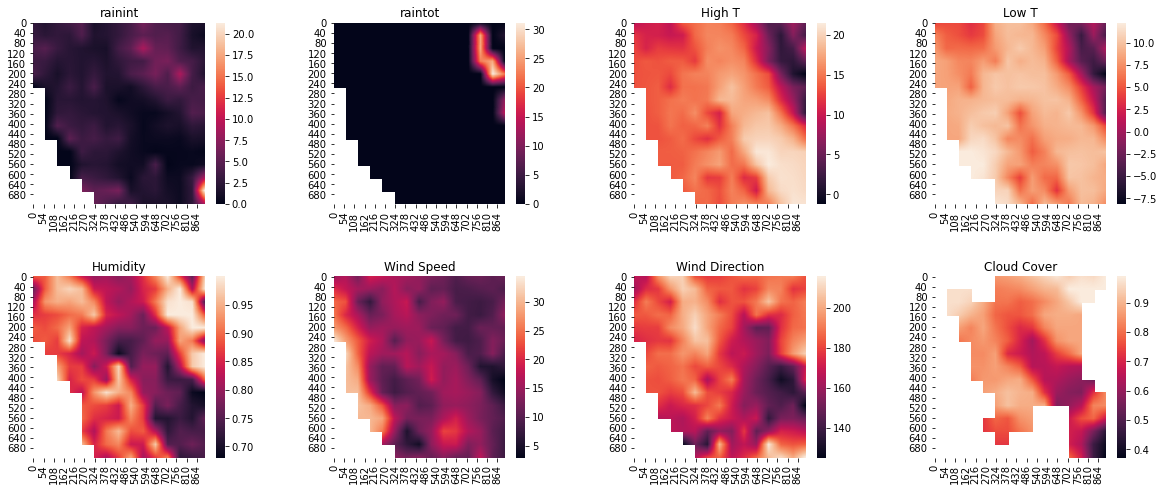

Year2010


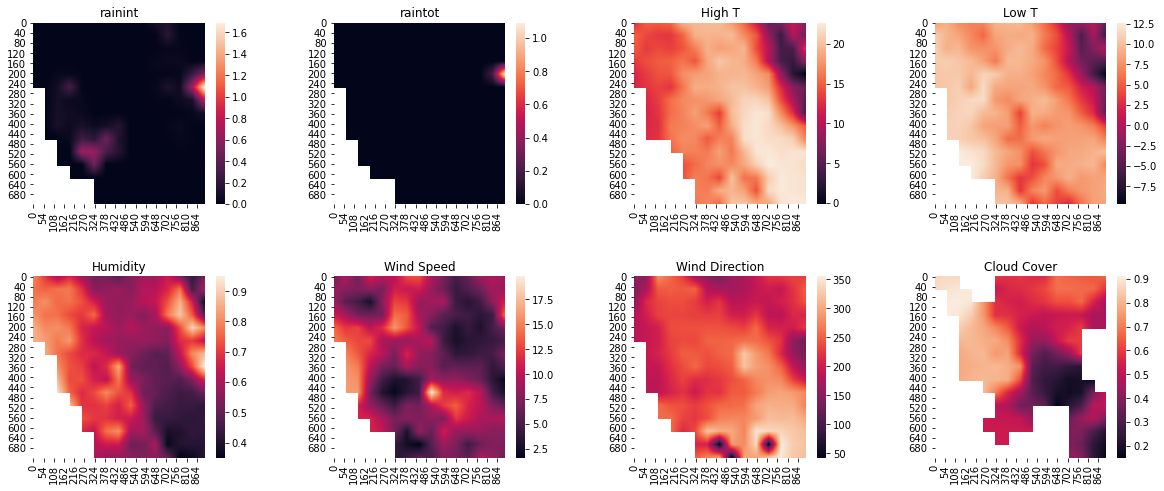

Year2011


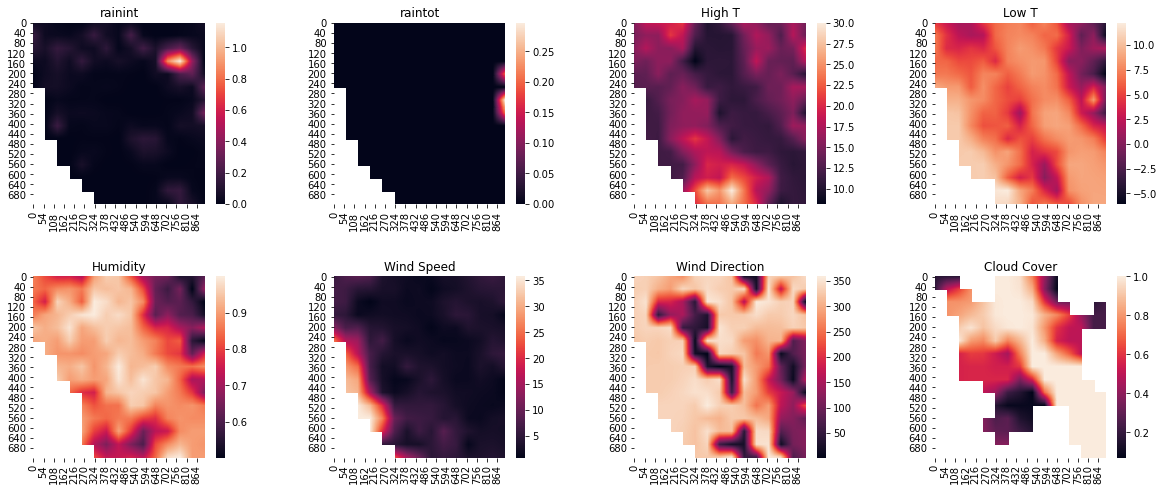

Year2012


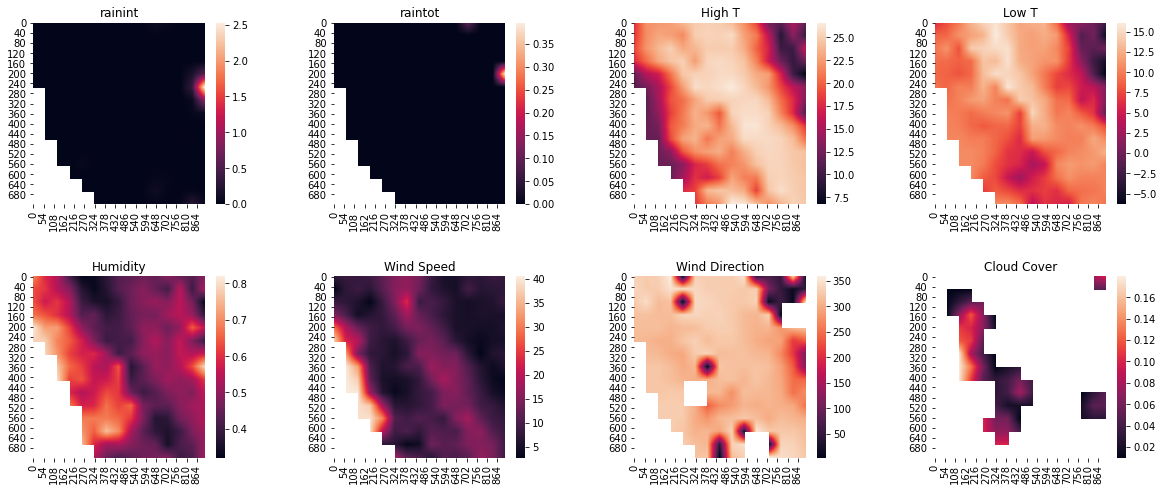

Year2014


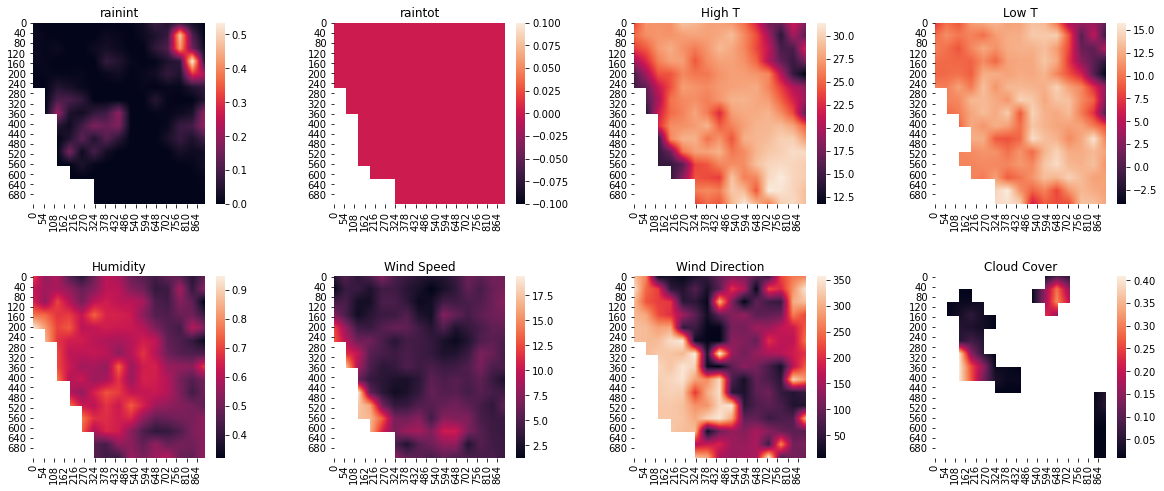

Year2015


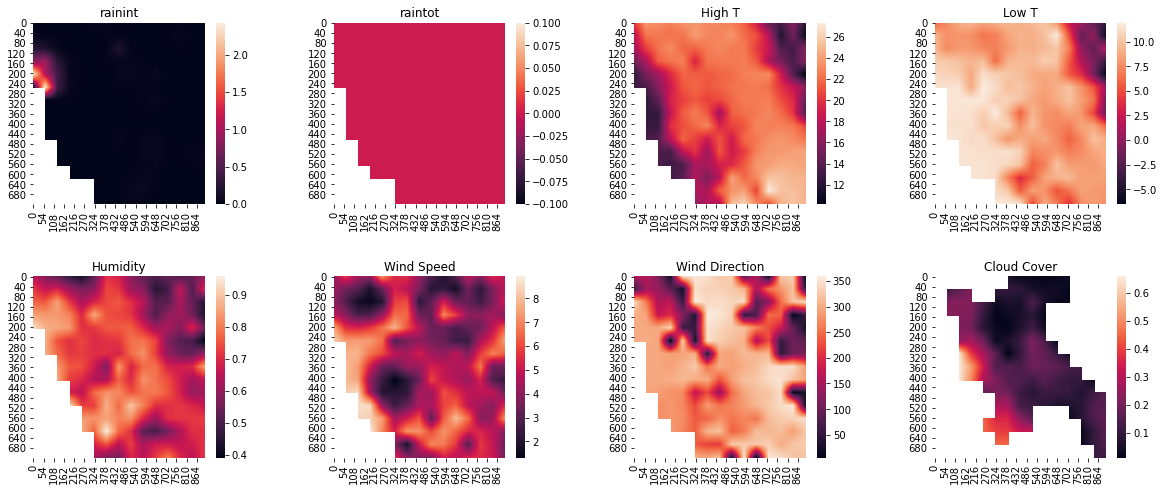

Year2016


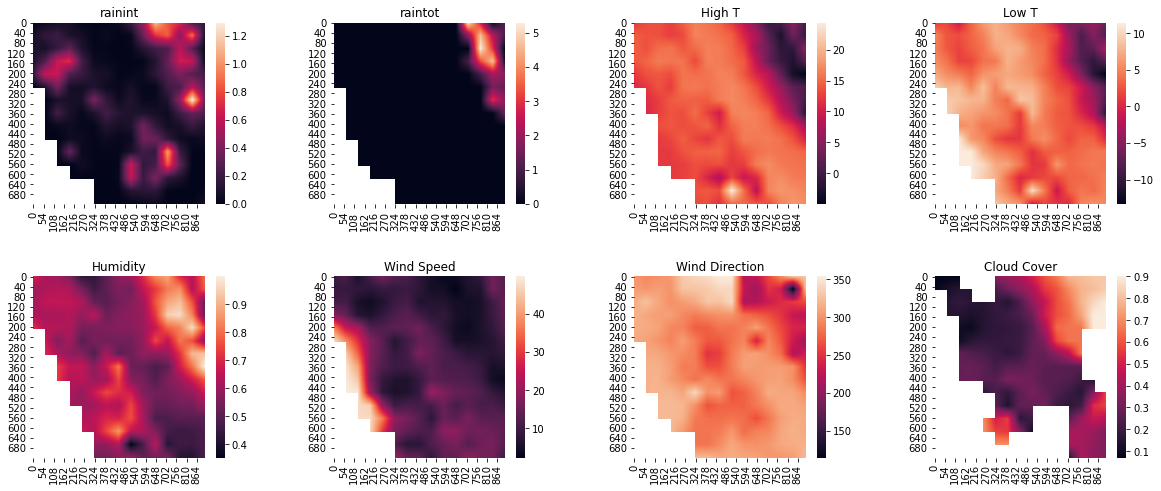

In [7]:
import pickle
for year in years:
    path = '../data/GlobalFire/'+year+'/'   
    filename = 'weather'+year+'data.pickle'
    filestring = path+filename
    with open(filestring,'rb') as f:
        y1 = pickle.load(f)
    tenthday = list(y1.keys())[9]
    x1 = y1[tenthday] #arbitrary day
    print(f"Year{year}")
    plot_weather(x1)

# Extra Code

In [46]:
# Return from pickle for further work
import pickle
with open('../data/GlobalFire/2003/weatherarrays.pickle','rb') as f:
    z = pickle.load(f)   

In [48]:
z.keys()

dict_keys(['2003-01-10', '2003-01-11', '2003-01-12', '2003-01-13', '2003-01-14', '2003-01-15', '2003-01-16', '2003-01-17', '2003-02-25', '2003-02-26', '2003-02-27', '2003-02-28', '2003-03-01', '2003-03-02', '2003-03-03', '2003-03-04', '2003-03-05', '2003-03-06', '2003-03-07', '2003-03-08', '2003-03-09', '2003-03-10', '2003-03-11', '2003-03-12', '2003-03-14', '2003-03-15', '2003-03-16', '2003-03-17', '2003-03-18', '2003-03-19', '2003-03-20', '2003-03-21', '2003-03-22', '2003-03-23', '2003-03-25', '2003-03-30', '2003-05-02', '2003-05-03', '2003-05-04', '2003-05-05', '2003-05-06', '2003-05-07', '2003-05-08', '2003-05-09', '2003-05-10', '2003-05-11', '2003-05-18', '2003-05-19', '2003-05-20', '2003-05-21', '2003-05-22', '2003-05-26', '2003-05-29', '2003-05-30', '2003-05-31', '2003-06-01', '2003-06-02', '2003-06-03', '2003-06-04', '2003-06-05', '2003-06-07', '2003-06-08', '2003-06-15', '2003-06-16', '2003-06-17', '2003-06-18', '2003-06-19', '2003-06-20', '2003-06-21', '2003-07-03', '2003-07-

In [49]:
len(z)

179

In [ ]:
z['2003-01-10']